# Aliyat - Board and Pieces
## Functional Testing

### Introduction
This notebook outlines the development of a computer based chess game from scratch. We are using a functional testing approach with [pytest](https://docs.pytest.org/en/7.3.x/) and [ipytest](https://pypi.org/project/ipytest/). The main advantages of functional testing are readibility, quality assurance and over all better code. This project is fairly complex and from the start we set up a testing framework that allowed us to write small pieces of code and test as we developed. 

In [1]:
## Importing relevant libraries

In [2]:
import re

In [3]:
import numpy as np
import pylab as plt
from matplotlib.patches import RegularPolygon, Circle
from matplotlib.animation import FuncAnimation

In [4]:
import pytest
import ipytest

In [5]:
## Relevant info about pieces and board

In [6]:
# d_pos maps the algebraic position in the board to a numerical grid coordinates (e.g. a1 -> (0,0))
# d_sop maps a numerical grid coordinates to the algebraic position in the board to (e.g. (0,0) -> a1)
d_pos = {}
d_sop = {}
l_ranks = ['1','2','3','4','5','6','7','8']
l_files = ['a','b','c','d','e','f','g','h']
for ii in range(len(l_ranks)):
    for jj in range(len(l_files)):
        d_pos[l_files[ii] + l_ranks[jj]] = (ii,jj)
        d_sop[(ii,jj)] = l_files[ii] + l_ranks[jj]
# d_pieces maps the pieces codes to the ASCII characters 
d_pieces = {'wK':u'\u2654','wQ':u'\u2655','wR':u'\u2656','wB':u'\u2657','wN':u'\u2658','wp':u'\u2659','bK':u'\u265A','bQ':u'\u265B','bR':u'\u265C','bB':u'\u265D','bN':u'\u265E','bp':u'\u265F'}
# d_board_standard is the initial setting of the board in a typical chess game
d_board_standard = {'wpa2':'a2','wpb2':'b2','wpc2':'c2','wpd2':'d2','wpe2':'e2','wpf2':'f2','wpg2':'g2','wph2':'h2',
           'wRa1':'a1','wNb1':'b1','wBc1':'c1','wQd1':'d1','wKe1':'e1','wBf1':'f1','wNg1':'g1','wRh1':'h1',
           'bpa7':'a7','bpb7':'b7','bpc7':'c7','bpd7':'d7','bpe7':'e7','bpf7':'f7','bpg7':'g7','bph7':'h7',
           'bRa8':'a8','bNb8':'b8','bBc8':'c8','bQd8':'d8','bKe8':'e8','bBf8':'f8','bNg8':'g8','bRh8':'h8'}

In [7]:
# possible moves for pieces. Includes special moves for knight
n = np.array([0,1])
s = np.array([0,-1])
e = np.array([1,0])
w = np.array([-1,0])
ne = np.array([1,1])
nw = np.array([-1,1])
se = np.array([1,-1])
sw = np.array([-1,-1])
k1 = np.array([2,1])
k2 = np.array([2,-1])
k3 = np.array([-2,1])
k4 = np.array([-2,-1])
k5 = np.array([1,2])
k6 = np.array([-1,2])
k7 = np.array([-1,-2])
k8 = np.array([1,-2])

In [8]:
# possible moves per piece
d_moves = {'wp':[n,ne,nw],
           'bp':[s,se,sw],
           'Q':[ii*n for ii in range(1,8)] + [ii*ne for ii in range(1,8)] + [ii*e for ii in range(1,8)] + [ii*se for ii in range(1,8)] + [ii*s for ii in range(1,8)] + [ii*sw for ii in range(1,8)] + [ii*w for ii in range(1,8)] + [ii*nw for ii in range(1,8)] ,
           'R':[ii*n for ii in range(1,8)] + [ii*e for ii in range(1,8)] + [ii*s for ii in range(1,8)] + [ii*w for ii in range(1,8)],
           'B':[ii*ne for ii in range(1,8)] + [ii*se for ii in range(1,8)] + [ii*sw for ii in range(1,8)] + [ii*nw for ii in range(1,8)],
           'N':[k1,k2,k3,k4,k5,k6,k7,k8],
           'K':[n,s,e,w,ne,nw,sw,se]}

In [9]:
## Relevant functions:

In [10]:
def print_board(board_positions):
    # Objective: prints a chess board with pieces in positions defined by the user
    # Input: a dictionary with positions of pieces in the board
    # Output: a matplotlib figure with the board and pieces in the specified positions
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.add_patch(RegularPolygon((4,4),4,8.5/np.sqrt(2),orientation=np.pi/4,color='gray'))
    for pos in d_pos.keys():
        coord = d_pos[pos]
        if (coord[0] + coord[1]) %2 == 1:
            ax.add_patch(RegularPolygon((coord[0]+0.5,coord[1]+0.5),4,1/np.sqrt(2),orientation=np.pi/4,color='white',alpha=0.5))
            plt.text(coord[0],coord[1],pos,color='black')
        else:
            ax.add_patch(RegularPolygon((coord[0]+0.5,coord[1]+0.5),4,1/np.sqrt(2),orientation=np.pi/4,color='#696969',alpha=0.5))
            plt.text(coord[0],coord[1],pos,color='white')

    for item in board_positions.items():
        if item[1] != '_Captured':
            coord = d_pos[item[1]]
            plt.text(coord[0]+0.5,coord[1]+0.4,d_pieces[item[0][:2]],fontsize=60,va='center',ha='center')

    plt.xlim([-0.5,8.5])
    plt.ylim([-0.5,8.5])
    plt.show()
    return ax

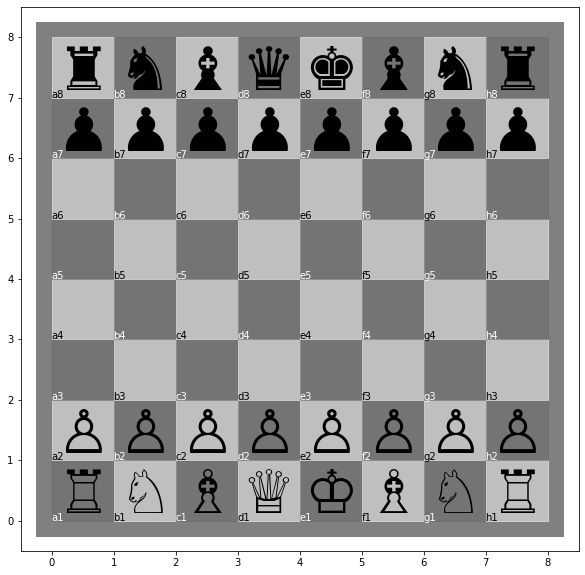

In [11]:
print_board(d_board_standard)
plt.show()

In [12]:
def print_board_img(board_positions,img_name):
    # Objective: prints a chess board with pieces in positions defined by the user as png
    # Input: - a dictionary with positions of pieces in the board
    #        - an image name
    # Output: a matplotlib figure with the board and pieces in the specified positions as png with given name
    fig, ax = plt.subplots(figsize=(10,10))
    ax.add_patch(RegularPolygon((4,4),4,8.5/np.sqrt(2),orientation=np.pi/4,color='gray'))
    for pos in d_pos.keys():
        coord = d_pos[pos]
        if (coord[0] + coord[1]) %2 == 1:
            ax.add_patch(RegularPolygon((coord[0]+0.5,coord[1]+0.5),4,1/np.sqrt(2),orientation=np.pi/4,color='white',alpha=0.5))
            plt.text(coord[0],coord[1],pos,color='black')
        else:
            ax.add_patch(RegularPolygon((coord[0]+0.5,coord[1]+0.5),4,1/np.sqrt(2),orientation=np.pi/4,color='#696969',alpha=0.5))
            plt.text(coord[0],coord[1],pos,color='white')

    for item in board_positions.items():
        if item[1] != '_Captured':
            coord = d_pos[item[1]]
            plt.text(coord[0]+0.5,coord[1]+0.4,d_pieces[item[0][:2]],fontsize=60,va='center',ha='center')


    plt.xlim([-0.5,8.5])
    plt.ylim([-0.5,8.5])
    plt.savefig('Board' + img_name + '.png')
    return ax

In [13]:
# given the board piece name, get the color. It is a very simple funtion but helps with readibility
def get_board_piece_color(board_piece_name):
    return(board_piece_name[0])
# given the board position dictionary, defines a new dictionary with the piece located on each position
def get_board_position_inverse(board_position):
    d = {}
    for item in board_position.items():
        d[item[1]] = item[0]
    return(d)

### Defining possible moves

In [14]:
def possible_moves_pawn(color,position):
    # Objective: defines possible moves for a pawn given its color and position. Note: possible move might not be legal
    # Input: pawn color
    #        pawn position
    # Output: a list of possible moves. 

    if (color == 'w' and int(position[1]) == 1) or (color == 'b' and int(position[1]) == 8):
        return(['_Not a legal position'])
    if (color == 'w' and int(position[1]) == 2) or (color == 'b' and int(position[1]) == 7):
        list_of_squares = [d_pos[position] + move for move in d_moves[color+'p']] + [d_pos[position] + 2*d_moves[color+'p'][0]]
        list_of_squares_on_board = [move for move in list_of_squares if 0<=move[0]<=7 and 0<=move[1]<=7]
        list_of_moves = [d_sop[tuple(move)] for move in list_of_squares_on_board]
        return list_of_moves
    if (color == 'w' and 6>=int(position[1]) > 2) or (color == 'b' and 3<=int(position[1]) < 7):
        list_of_squares = [d_pos[position] + move for move in d_moves[color+'p']]
        list_of_squares_on_board = [move for move in list_of_squares if 0<=move[0]<=7 and 0<=move[1]<=7]
        list_of_moves = [d_sop[tuple(move)] for move in list_of_squares_on_board]
        return list_of_moves
    if (color == 'w' and int(position[1]) == 7) or (color == 'b' and int(position[1]) == 2):
        list_of_squares = [d_pos[position] + move for move in d_moves[color+'p']]
        list_of_squares_on_board = [move for move in list_of_squares if 0<=move[0]<=7 and 0<=move[1]<=7]
        list_of_moves = [d_sop[tuple(move)] for move in list_of_squares_on_board]
        return [['_Promotion'] + [move] for move in list_of_moves]

In [15]:
def test_legal_position_pawn():
    # Inputs: color - so I know the direction of motion
    #         position
    # There is no way to find any white/black pawn in the first/eighth rank
    assert possible_moves_pawn('w','a1') == ['_Not a legal position']
    assert possible_moves_pawn('w','b1') == ['_Not a legal position']
    assert possible_moves_pawn('w','c1') == ['_Not a legal position']
    assert possible_moves_pawn('w','d1') == ['_Not a legal position']
    assert possible_moves_pawn('w','e1') == ['_Not a legal position']
    assert possible_moves_pawn('w','e1') == ['_Not a legal position']
    assert possible_moves_pawn('w','f1') == ['_Not a legal position']
    assert possible_moves_pawn('w','g1') == ['_Not a legal position']
    assert possible_moves_pawn('w','h1') == ['_Not a legal position']
    assert possible_moves_pawn('b','a8') == ['_Not a legal position']
    assert possible_moves_pawn('b','b8') == ['_Not a legal position']
    assert possible_moves_pawn('b','c8') == ['_Not a legal position']
    assert possible_moves_pawn('b','d8') == ['_Not a legal position']
    assert possible_moves_pawn('b','e8') == ['_Not a legal position']
    assert possible_moves_pawn('b','f8') == ['_Not a legal position']
    assert possible_moves_pawn('b','g8') == ['_Not a legal position']
    assert possible_moves_pawn('b','h8') == ['_Not a legal position']

def test_possible_moves_pawn_initial_move():
    # If pawn is in starting position, it can move along the file either on or two squares; and can capture if there is a piece in the adjacent file/rank
    assert set(possible_moves_pawn('w','a2')) == set(['a3','a4','b3'])
    assert set(possible_moves_pawn('b','a7')) == set(['a6','a5','b6'])
    assert set(possible_moves_pawn('w','b2')) == set(['b3','b4','a3','c3'])
    assert set(possible_moves_pawn('b','b7')) == set(['b6','b5','a6','c6'])

def test_possible_moves_pawn_not_initial_move_not_promotion(): 
    # If pawn is not in the starting position or next to promotion
    assert set(possible_moves_pawn('b','a4')) == set(['a3','b3'])
    

def test_possible_moves_pawn_promotion():
    # If pawn in at the opposite end of the board it will be promoted
    assert possible_moves_pawn('w','a7') == [['_Promotion','a8'],['_Promotion','b8']]
    

In [16]:
ipytest.run()

======================================= test session starts ========================================
platform darwin -- Python 3.9.16, pytest-7.1.3, pluggy-1.0.0
rootdir: /Users/hugocontreras/Documents/DATA_SCIENCE_REVIEW_2023/Shatranj/notebooks
collected 4 items

t_9043a1c056044cf68e69e4f9f679e2ad.py ....                                                   [100%]

======================================== 4 passed in 0.13s =========================================


<ExitCode.OK: 0>

In [17]:
def possible_moves_king(color,position):
    # Objective: defines possible moves for a king given its color and position. Note: possible move might not be legal
    # Input: king color
    #        king position
    # Output: a list of possible moves. 
    list_of_squares = [d_pos[position] + move for move in d_moves['K']]
    list_of_squares_on_board = [move for move in list_of_squares if 0<=move[0]<=7 and 0<=move[1]<=7]
    list_of_moves = [d_sop[tuple(move)] for move in list_of_squares_on_board]
    return list_of_moves

In [18]:
def test_possible_moves_king():
    # center
    assert set(possible_moves_king('w','e5')) == set(['d6','e6','f6','d5','f5','d4','e4','f4'])
    # border
    assert set(possible_moves_king('w','a5')) == set(['a6','b6','b5','a4','b4'])
    # corner
    assert set(possible_moves_king('w','a1')) == set(['a2','b2','b1'])

In [19]:
def possible_moves_queen(color,position):
    # Objective: defines possible moves for a queen given its color and position. Note: possible move might not be legal
    # Input: queen color
    #        queen position
    # Output: a list of possible moves. 
    list_of_squares = [d_pos[position] + move for move in d_moves['Q']]
    list_of_squares_on_board = [move for move in list_of_squares if 0<=move[0]<=7 and 0<=move[1]<=7]
    list_of_moves = [d_sop[tuple(move)] for move in list_of_squares_on_board]
    return list_of_moves

In [20]:
def test_possible_moves_queen():
    # center
    assert set(possible_moves_queen('w','e5')) == set(['e1','e2','e3','e4','e6','e7','e8','a5','b5','c5','d5','f5','g5','h5','a1','b2','c3','d4','f6','g7','h8','h2','g3','f4','d6','c7','b8'])
    # border
    assert set(possible_moves_queen('w','a5')) == set(['a1','a2','a3','a4','a6','a7','a8','b5','c5','d5','e5','f5','g5','h5','b6','c7','d8','b4','c3','d2','e1'])
    # corner
    assert set(possible_moves_queen('w','a1')) == set(['a2','a3','a4','a5','a6','a7','a8','b1','c1','d1','e1','f1','g1','h1','b2','c3','d4','e5','f6','g7','h8'])

In [21]:
def possible_moves_rook(color,position):
    # Objective: defines possible moves for a rook given its color and position. Note: possible move might not be legal
    # Input: rook color
    #        rook position
    # Output: a list of possible moves. 
    list_of_squares = [d_pos[position] + move for move in d_moves['R']]
    list_of_squares_on_board = [move for move in list_of_squares if 0<=move[0]<=7 and 0<=move[1]<=7]
    list_of_moves = [d_sop[tuple(move)] for move in list_of_squares_on_board]
    return list_of_moves

In [22]:
def test_possible_moves_rook():
    # center
    assert set(possible_moves_rook('w','e5')) == set(['e1','e2','e3','e4','e6','e7','e8','a5','b5','c5','d5','f5','g5','h5'])
    # border
    assert set(possible_moves_rook('w','a5')) == set(['a1','a2','a3','a4','a6','a7','a8','b5','c5','d5','e5','f5','g5','h5'])
    # corner
    assert set(possible_moves_rook('w','a1')) == set(['a2','a3','a4','a5','a6','a7','a8','b1','c1','d1','e1','f1','g1','h1'])

In [23]:
def possible_moves_bishop(color,position):
    # Objective: defines possible moves for a bishop given its color and position. Note: possible move might not be legal
    # Input: bishop color
    #        bishop position
    # Output: a list of possible moves. 
    list_of_squares = [d_pos[position] + move for move in d_moves['B']]
    list_of_squares_on_board = [move for move in list_of_squares if 0<=move[0]<=7 and 0<=move[1]<=7]
    list_of_moves = [d_sop[tuple(move)] for move in list_of_squares_on_board]
    return list_of_moves

In [24]:
def test_possible_moves_bishop():
    # center
    assert set(possible_moves_bishop('w','e5')) == set(['a1','b2','c3','d4','f6','g7','h8','h2','g3','f4','d6','c7','b8'])
    # border
    assert set(possible_moves_bishop('w','a5')) == set(['b6','c7','d8','b4','c3','d2','e1'])
    # corner
    assert set(possible_moves_bishop('w','a1')) == set(['b2','c3','d4','e5','f6','g7','h8'])

In [25]:
def possible_moves_knight(color,position):
    # Objective: defines possible moves for a knight given its color and position. Note: possible move might not be legal
    # Input: knight color
    #        knight position
    # Output: a list of possible moves. 
    list_of_squares = [d_pos[position] + move for move in d_moves['N']]
    list_of_squares_on_board = [move for move in list_of_squares if 0<=move[0]<=7 and 0<=move[1]<=7]
    list_of_moves = [d_sop[tuple(move)] for move in list_of_squares_on_board]
    return list_of_moves

In [26]:
def test_possible_moves_knight():
    # center
    assert set(possible_moves_knight('w','e5')) == set(['d7','f7','g4','g6','d3','f3','c4','c6'])
    # border
    assert set(possible_moves_knight('w','a5')) == set(['b7','c6','c4','b3'])
    # corner
    assert set(possible_moves_knight('w','a1')) == set(['b3','c2'])

In [27]:
def possible_moves_non_pawn(piece_code,color,position):
    # Objective: defines possible moves for a non-pawn given its color and position. Note: possible move might not be legal
    # Input: piece code
    #        piece color
    #        piece position
    # Output: a list of possible moves. 
    list_of_squares = [d_pos[position] + move for move in d_moves[piece_code]]
    list_of_squares_on_board = [move for move in list_of_squares if 0<=move[0]<=7 and 0<=move[1]<=7]
    list_of_moves = [d_sop[tuple(move)] for move in list_of_squares_on_board]
    return list_of_moves

In [28]:
def get_possible_moves(piece_code,color,position):
    # Objective: defines possible moves for any piece given its color and position. Note: possible move might not be legal
    # Input: pawn color
    #        pawn position
    # Output: a list of possible moves. 
    if piece_code == 'p':
        list_of_possible_moves = possible_moves_pawn(color,position)
    else:
        list_of_possible_moves = possible_moves_non_pawn(piece_code,color,position)
    return(list_of_possible_moves)

In [29]:
def test_get_possible_moves():
    # center
    assert set(possible_moves_non_pawn('N','w','e5')) == set(['d7','f7','g4','g6','d3','f3','c4','c6'])
    # border
    assert set(possible_moves_non_pawn('N','w','a5')) == set(['b7','c6','c4','b3'])
    # corner
    assert set(possible_moves_non_pawn('N','w','a1')) == set(['b3','c2'])

In [30]:
ipytest.run()

======================================= test session starts ========================================
platform darwin -- Python 3.9.16, pytest-7.1.3, pluggy-1.0.0
rootdir: /Users/hugocontreras/Documents/DATA_SCIENCE_REVIEW_2023/Shatranj/notebooks
collected 10 items

t_9043a1c056044cf68e69e4f9f679e2ad.py ..........                                             [100%]

======================================== 10 passed in 0.27s ========================================


<ExitCode.OK: 0>

### Defining possible moves

In [31]:
def get_legal_moves_pawn(piece_code,color,position,board_positions):
    # Objective: defines legal moves for a pawn given its color and position and board position dictionary. 
    # Input: pawn code (='p')
    #        pawn color
    #        pawn position
    #        board position
    # Output: a list of possible moves.
    # Notes: 
    # Two cases left:
    # 1. En Passant
    # 2. Capture and promotion
    # it can be improved to reduce redundancy
    board_positions_inverse = get_board_position_inverse(board_positions)
    list_of_possible_moves = get_possible_moves(piece_code,color,position)
    list_of_possible_moves_captures = []
    list_of_possible_moves_clear = []
    if piece_code == 'p':
        list_of_possible_moves = get_possible_moves(piece_code,color,position)
        if (color == 'w' and int(position[1]) == 2) or (color == 'b' and int(position[1]) == 7):

            if list_of_possible_moves[0] not in board_positions.values():
                list_of_possible_moves_clear.append(list_of_possible_moves[0])
            if list_of_possible_moves[0] not in board_positions.values() and list_of_possible_moves[-1] not in board_positions.values():
                list_of_possible_moves_clear.append(list_of_possible_moves[-1])
            for move in list_of_possible_moves[1:-1]:
                if move in board_positions.values() and board_positions_inverse[move][0]!=color:
                    list_of_possible_moves_captures.append(['_Capture',move,board_positions_inverse[move]])
        else:

            if list_of_possible_moves[0] not in board_positions.values():
                list_of_possible_moves_clear.append(list_of_possible_moves[0])
            for move in list_of_possible_moves[1:]:
                if move in board_positions.values() and board_positions_inverse[move][0]!=color:
                    list_of_possible_moves_captures.append(['_Capture',move,board_positions_inverse[move]])
    return(list_of_possible_moves_clear,list_of_possible_moves_captures)

In [32]:
def test_get_legal_moves_pawn():
    assert set(get_legal_moves_pawn('p','w','b2',d_board_standard)[0]) == set(['b3','b4'])
    assert get_legal_moves_pawn('p','w','b2',d_board_standard)[1] == []
    d_board_example = d_board_standard.copy()
    d_board_example['bQd8'] = 'a3'
    assert set(get_legal_moves_pawn('p','w','b2',d_board_example)[0]) == set(['b3','b4'])
    assert get_legal_moves_pawn('p','w','b2',d_board_example)[1] == [['_Capture','a3', 'bQd8']]
    
    assert set(get_legal_moves_pawn('p','w','b3',d_board_standard)[0]) == set(['b4'])
    d_board_example = d_board_standard.copy()
    d_board_example['bQd8'] = 'a4'
    assert set(get_legal_moves_pawn('p','w','b3',d_board_example)[0]) == set(['b4'])
    assert get_legal_moves_pawn('p','w','b3',d_board_example)[1] == [['_Capture','a4', 'bQd8']]
    
    assert set(get_legal_moves_pawn('p','b','b7',d_board_standard)[0]) == set(['b6','b5'])
    assert get_legal_moves_pawn('p','b','b7',d_board_standard)[1] == []

In [33]:
def get_legal_moves_king(piece_code,color,position,board_positions):
    # Objective: defines legal moves for a king given its color and position and board position dictionary. 
    # Input: king code (='K')
    #        king color
    #        king position
    #        board position
    # Output: a list of possible moves.
    # Notes: 
    # it can be improved to reduce redundancy
    board_positions_inverse = get_board_position_inverse(board_positions)
    #print(board_positions_inverse)
    list_of_possible_moves = get_possible_moves(piece_code,color,position)
    #print(list_of_possible_moves)
    list_of_possible_moves_captures = []
    list_of_possible_moves_clear = []
    if piece_code == 'K':
        for move in list_of_possible_moves:
            if move in board_positions.values() and board_positions_inverse[move][0]!=color:
                list_of_possible_moves_captures.append(['_Capture',move,board_positions_inverse[move]])
            if move not in board_positions.values():
                list_of_possible_moves_clear.append(move)
    return(list_of_possible_moves_clear,list_of_possible_moves_captures)

In [34]:
def test_get_legal_moves_king():
    assert get_legal_moves_king('K','w','e1',d_board_standard)[0] == []
    assert get_legal_moves_king('K','w','e1',d_board_standard)[1] == []
    
    d_board_example = d_board_standard.copy()
    d_board_example['wKe1'] = 'e4'
    assert set(get_legal_moves_king('K','w','e4',d_board_example)[0]) == set(['d5','e5','f5','d4','f4','d3','e3','f3'])
    assert get_legal_moves_king('K','w','e4',d_board_example)[1] == []

In [35]:
def get_legal_moves_knight(piece_code,color,position,board_positions):
    # Objective: defines legal moves for a knight given its color and position and board position dictionary. 
    # Input: knight code (='N')
    #        knight color
    #        knight position
    #        board position
    # Output: a list of possible moves.
    # Notes: 
    # it can be improved to reduce redundancy
    board_positions_inverse = get_board_position_inverse(board_positions)
    list_of_possible_moves = get_possible_moves(piece_code,color,position)
    list_of_possible_moves_captures = []
    list_of_possible_moves_clear = []
    if piece_code == 'N':
        for move in list_of_possible_moves:
            if move in board_positions.values() and board_positions_inverse[move][0]!=color:
                list_of_possible_moves_captures.append(['_Capture',move,board_positions_inverse[move]])
            if move not in board_positions.values():
                list_of_possible_moves_clear.append(move)
    return(list_of_possible_moves_clear,list_of_possible_moves_captures)

In [36]:
def test_get_legal_moves_knight():
    assert set(get_legal_moves_knight('N','w','g1',d_board_standard)[0]) == set(['f3','h3'])
    assert get_legal_moves_knight('N','w','g1',d_board_standard)[1] == []
    
    d_board_example1 = d_board_standard.copy()
    d_board_example1['wKe1'] = 'h3'
    assert set(get_legal_moves_knight('N','w','g1',d_board_example1)[0]) == set(['f3'])
    assert get_legal_moves_knight('N','w','g1',d_board_example1)[1] == []
    
    d_board_example2 = d_board_standard.copy()
    d_board_example2['bQd8'] = 'h3'
    assert set(get_legal_moves_knight('N','w','g1',d_board_example2)[0]) == set(['f3'])
    assert get_legal_moves_knight('N','w','g1',d_board_example2)[1] == [['_Capture','h3','bQd8']]

In [37]:
def get_legal_moves_rook(piece_code,color,position,board_positions):
    # Objective: defines legal moves for a rook given its color and position and board position dictionary. 
    # Input: rook code (='R')
    #        rook color
    #        rook position
    #        board position
    # Output: a list of possible moves.
    # Notes: 
    # it can be improved to reduce redundancy
    board_positions_inverse = get_board_position_inverse(board_positions)
    list_of_possible_moves = get_possible_moves(piece_code,color,position)
    list_of_possible_moves_captures = []
    list_of_possible_moves_clear = []
    if piece_code == 'R':

        for ii in range(len(d_moves['R'])//7):
            l_section = d_moves['R'][ii*7:(ii+1)*7]
            flag = True
            jj = 0
            while flag == True and jj<len(l_section):
                square = d_pos[position] + l_section[jj]
                if 0<=square[0]<=7 and 0<=square[1]<=7:
                    move = d_sop[tuple(square)]
                    if move not in board_positions.values():
                        list_of_possible_moves_clear.append(move)
                    else:
                        if move in board_positions.values() and board_positions_inverse[move][0]==color:
                            flag = False
                        if move in board_positions.values() and board_positions_inverse[move][0]!=color:
                            list_of_possible_moves_captures.append(['_Capture',move,board_positions_inverse[move]])
                            flag = False
                jj = jj + 1
                
        
    return(list_of_possible_moves_clear,list_of_possible_moves_captures)    

In [38]:
def test_get_legal_moves_rook():
    assert get_legal_moves_rook('R','w','h1',d_board_standard)[0] == []
    assert get_legal_moves_rook('R','w','h1',d_board_standard)[1] == []
    assert get_legal_moves_rook('R','b','h8',d_board_standard)[0] == []
    assert get_legal_moves_rook('R','b','h8',d_board_standard)[1] == []
    
    d_board_example1 = d_board_standard.copy()
    d_board_example1['bRh8'] = 'h4'
    assert set(get_legal_moves_rook('R','b','h4',d_board_example1)[0]) == set(['h3','h5','h6','a4','b4','c4','d4','e4','f4','g4'])
    assert get_legal_moves_rook('R','b','h4',d_board_example1)[1] == [['_Capture','h2','wph2']]
    

In [39]:
def get_legal_moves_bishop(piece_code,color,position,board_positions):
    # Objective: defines legal moves for a bishop given its color and position and board position dictionary. 
    # Input: bishop code (='B')
    #        bishop color
    #        bishop position
    #        board position
    # Output: a list of possible moves.
    # Notes: 
    # it can be improved to reduce redundancy
    board_positions_inverse = get_board_position_inverse(board_positions)
    list_of_possible_moves = get_possible_moves(piece_code,color,position)
    list_of_possible_moves_captures = []
    list_of_possible_moves_clear = []
    if piece_code == 'B':

        for ii in range(len(d_moves['B'])//7):
            l_section = d_moves['B'][ii*7:(ii+1)*7]
            flag = True
            jj = 0
            while flag == True and jj<len(l_section):
                square = d_pos[position] + l_section[jj]
                if 0<=square[0]<=7 and 0<=square[1]<=7:
                    move = d_sop[tuple(square)]
                    #print(move)
                    if move not in board_positions.values():
                        list_of_possible_moves_clear.append(move)
                    else:
                        if move in board_positions.values() and board_positions_inverse[move][0]==color:
                            flag = False
                        if move in board_positions.values() and board_positions_inverse[move][0]!=color:
                            list_of_possible_moves_captures.append(['_Capture',move,board_positions_inverse[move]])
                            flag = False
                jj = jj + 1
                
        
    return(list_of_possible_moves_clear,list_of_possible_moves_captures)    

In [40]:
def test_get_legal_moves_bishop():
    assert get_legal_moves_bishop('B','w','f1',d_board_standard)[0] == []
    assert get_legal_moves_bishop('B','w','f1',d_board_standard)[1] == []
    assert get_legal_moves_bishop('B','b','f8',d_board_standard)[0] == []
    assert get_legal_moves_bishop('B','b','f8',d_board_standard)[1] == []
    
    d_board_example1 = d_board_standard.copy()
    d_board_example1['bBf8'] = 'h4'
    assert set(get_legal_moves_bishop('B','b','h4',d_board_example1)[0]) == set(['g5','f6','g3'])
    assert get_legal_moves_bishop('B','b','h4',d_board_example1)[1] == [['_Capture','f2','wpf2']]

In [41]:
def get_legal_moves_queen(piece_code,color,position,board_positions):
    # Objective: defines legal moves for a queen given its color and position and board position dictionary. 
    # Input: queen code (='Q')
    #        queen color
    #        queen position
    #        board position
    # Output: a list of possible moves.
    # Notes: 
    # it can be improved to reduce redundancy
    board_positions_inverse = get_board_position_inverse(board_positions)
    list_of_possible_moves = get_possible_moves(piece_code,color,position)
    list_of_possible_moves_captures = []
    list_of_possible_moves_clear = []
    if piece_code == 'Q':

        for ii in range(len(d_moves['Q'])//7):
            l_section = d_moves['Q'][ii*7:(ii+1)*7]
            flag = True
            jj = 0
            while flag == True and jj<len(l_section):
                square = d_pos[position] + l_section[jj]
                if 0<=square[0]<=7 and 0<=square[1]<=7:
                    move = d_sop[tuple(square)]
                    if move not in board_positions.values():
                        list_of_possible_moves_clear.append(move)
                    else:
                        if move in board_positions.values() and board_positions_inverse[move][0]==color:
                            flag = False
                        if move in board_positions.values() and board_positions_inverse[move][0]!=color:
                            list_of_possible_moves_captures.append(['_Capture',move,board_positions_inverse[move]])
                            flag = False
                jj = jj + 1
                
        
    return(list_of_possible_moves_clear,list_of_possible_moves_captures)    

In [42]:
def get_legal_moves(piece_code,color,position,board_positions):
    if piece_code == 'p':
        return get_legal_moves_pawn(piece_code,color,position,board_positions)
    if piece_code == 'K':
        return get_legal_moves_king(piece_code,color,position,board_positions) 
    if piece_code == 'N':
        return get_legal_moves_knight(piece_code,color,position,board_positions)
    if piece_code == 'B':
        return get_legal_moves_bishop(piece_code,color,position,board_positions)
    if piece_code == 'R':
        return get_legal_moves_rook(piece_code,color,position,board_positions)
    if piece_code == 'Q':
        return get_legal_moves_queen(piece_code,color,position,board_positions)

In [43]:
ipytest.run()

======================================= test session starts ========================================
platform darwin -- Python 3.9.16, pytest-7.1.3, pluggy-1.0.0
rootdir: /Users/hugocontreras/Documents/DATA_SCIENCE_REVIEW_2023/Shatranj/notebooks
collected 15 items

t_9043a1c056044cf68e69e4f9f679e2ad.py ...............                                        [100%]

======================================== 15 passed in 0.33s ========================================


<ExitCode.OK: 0>

### Gettting moves from a PGN 

In [44]:
def get_moves_from_game_to_list(game_moves):
    # Objective: convert a PGN (Portable Game notation)
    # Input: string - PGN 
    # Output: list of moves
    return [item.replace('+','').replace('#','') for item in [re.sub("[0-9]*\.",'',item) for item in game_moves.split()] if len(item)>0]

In [45]:
get_moves_from_game_to_list('1. e5 e4 2. Nf3')
#== ['e5','e4','Nf3']

['e5', 'e4', 'Nf3']

In [46]:
def test_get_moves_from_game_to_list():
    assert get_moves_from_game_to_list('1.e5') == ['e5']
    assert get_moves_from_game_to_list('1.e5 e4') == ['e5','e4']
    assert get_moves_from_game_to_list('1.e5 e4 2.Nf3') == ['e5','e4','Nf3']

In [47]:
    # A few cases:
    # - pawn move simple: one letter and one number - first letter is lower case
    # - piece move simple: two letters and one number - first letter is upper case, second letter is lower case
    # - capture move simple: contains an x. After the x is the destination
    # - piece move diambiguation: contains an additional letter or number to decide which piece moves
    # - capture disambiguation: contains an additional letter or number to decide which piece moves
    # - check: all of the above plus a +
    # - mate: all of the above plus a #
    # - promotion: contains a = sign
    

In [48]:
def move_piece_from_move_pawn_simple(board_positions,move,color):
    # Objective: move a pawn. No captures or promotions
    # Input: current board position
    #        move
    #        color (PGN does not specify color other than from parity of the element in the list)
    # Output: list of moves
    if re.match('[a-h][1-8]',move):
        piece = color + 'p' + move[0]
        l_possible_pieces = [key for key in board_positions.keys() if piece in key and board_positions[key]!='_Captured' ]
        for candidate in l_possible_pieces:
            clear_moves, capture_moves = get_legal_moves(candidate[1],color,board_positions[candidate],board_positions)
            if move[-2:] in clear_moves:
                return [candidate,move[-2:]]

In [49]:
def test_move_piece_from_move_pawn_simple():
    assert move_piece_from_move_pawn_simple(d_board_standard,'a3','w') == ['wpa2','a3']

In [50]:
def move_piece_from_move_pawn_simple_board(board_positions,move,color):
    # Objective: move a pawn and change the board position dictionary. No captures or promotions
    # Input: current board position
    #        move
    #        color (PGN does not specify color other than from parity of the element in the list)
    # Output: list of moves
    if re.match('[a-h][1-8]',move):
        piece = color + 'p' + move[0]
        l_possible_pieces = [key for key in board_positions.keys() if piece in key and board_positions[key]!='_Captured' ]
        for candidate in l_possible_pieces:
            clear_moves, capture_moves = get_legal_moves(candidate[1],color,board_positions[candidate],board_positions)
            if move[-2:] in clear_moves:
                board_positions[candidate] = move[-2:]
                return board_positions
    return board_positions

In [51]:
# Modify this test to include the change of the board
"""
def test_move_piece_from_move_pawn_simple():
    assert move_piece_from_move_pawn_simple(d_board_standard,'a3','w') == ['wpa2','a3']
"""

"\ndef test_move_piece_from_move_pawn_simple():\n    assert move_piece_from_move_pawn_simple(d_board_standard,'a3','w') == ['wpa2','a3']\n"

In [52]:
def move_piece_from_move_piece_simple(board_positions,move,color):
    # Objective: move a non-pawn. No captures 
    # Input: current board position
    #        move
    #        color (PGN does not specify color other than from parity of the element in the list)
    # Output: list of moves
    if re.match('[KQRNB][a-h][1-8]',move):
        piece = color + move[0]
        l_possible_pieces = [key for key in board_positions.keys() if piece in key and board_positions[key]!='_Captured' ]
        for candidate in l_possible_pieces:
            clear_moves, capture_moves = get_legal_moves(candidate[1],color,board_positions[candidate],board_positions)
            if move[-2:] in clear_moves:
                return [candidate,move[-2:]]

In [53]:
def test_move_piece_from_move_piece_simple():
    assert move_piece_from_move_piece_simple(d_board_standard,'Nf3','w') == ['wNg1','f3']

In [54]:
def move_piece_from_move_piece_simple_board(board_positions,move,color):
    # Objective: move a non-pawn and change the board position dictionary. No captures 
    # Input: current board position
    #        move
    #        color (PGN does not specify color other than from parity of the element in the list)
    # Output: list of moves
    if re.match('[KQRNB][a-h][1-8]',move):
        piece = color + move[0]
        l_possible_pieces = [key for key in board_positions.keys() if piece in key and board_positions[key]!='_Captured']
        for candidate in l_possible_pieces:
            clear_moves, capture_moves = get_legal_moves(candidate[1],color,board_positions[candidate],board_positions)
            if move[-2:] in clear_moves:
                board_positions[candidate] = move[-2:]
                return board_positions
    return board_positions

In [55]:
# Modify this test to include the change of the board
"""
def test_move_piece_from_move_piece_simple():
    assert move_piece_from_move_piece_simple(d_board_standard,'Nf3','w') == ['wNg1','f3']
"""

"\ndef test_move_piece_from_move_piece_simple():\n    assert move_piece_from_move_piece_simple(d_board_standard,'Nf3','w') == ['wNg1','f3']\n"

In [56]:
def move_piece_from_move_pawn_capture(board_positions,move,color):
    # Objective: move a pawn and change the board position dictionary. When captures 
    # Input: current board position
    #        move
    #        color (PGN does not specify color other than from parity of the element in the list)
    # Output: list of moves
    if re.match('[a-h][x][a-h][1-8]',move):
        piece = color + 'p'
        l_possible_pieces = [key for key in board_positions.keys() if piece in key and board_positions[key]!='_Captured']
        for candidate in l_possible_pieces:
            clear_moves, capture_moves = get_legal_moves(candidate[1],color,board_positions[candidate],board_positions)
            for item in capture_moves:
                if move[-2:] in item:
                    return [candidate,move[-2:]]



In [57]:
def test_move_piece_from_move_pawn_capture():
    d_board_example = d_board_standard.copy()
    d_board_example['bQd8'] = 'd4'
    d_board_example['wpe2'] = 'e3'
    assert move_piece_from_move_pawn_capture(d_board_example,'exd4','w') == ['wpe2','d4']

In [58]:
def move_piece_from_move_pawn_capture_board(board_positions,move,color):
    # Objective: move a pawn and change the board position dictionary. When captures 
    # Input: current board position
    #        move
    #        color (PGN does not specify color other than from parity of the element in the list)
    # Output: list of moves
    if re.match('[a-h][x][a-h][1-8]',move):
        piece = color + 'p'
        l_possible_pieces = [key for key in board_positions.keys() if piece in key and board_positions[key]!='_Captured']
        for candidate in l_possible_pieces:
            clear_moves, capture_moves = get_legal_moves(candidate[1],color,board_positions[candidate],board_positions)
            for item in capture_moves:
                if move[-2:] in item:
                    captured_piece = [item[0] for item in board_positions.items() if item[1]==move[-2:]]
                    board_positions[candidate] = move[-2:]
                    board_positions[captured_piece[0]] = '_Captured'
                    
                    return board_positions
    return board_positions

In [59]:
# Modify this test to include the change of the board
"""
def test_move_piece_from_move_pawn_capture():
    d_board_example = d_board_standard.copy()
    d_board_example['bQd8'] = 'd4'
    d_board_example['wpe2'] = 'e3'
    assert move_piece_from_move_pawn_capture(d_board_example,'exd4','w') == ['wpe2','d4']
"""

"\ndef test_move_piece_from_move_pawn_capture():\n    d_board_example = d_board_standard.copy()\n    d_board_example['bQd8'] = 'd4'\n    d_board_example['wpe2'] = 'e3'\n    assert move_piece_from_move_pawn_capture(d_board_example,'exd4','w') == ['wpe2','d4']\n"

In [60]:
def move_piece_from_move_piece_capture(board_positions,move,color):
    # Objective: move a non-pawn and change the board position dictionary. When captures
    # Input: current board position
    #        move
    #        color (PGN does not specify color other than from parity of the element in the list)
    # Output: updated board position dictionary
    if re.match('[BNKQR][x][a-h][1-8]',move):
        piece = color + move[0]
        l_possible_pieces = [key for key in board_positions.keys() if piece in key and board_positions[key]!='_Captured' ]
        for candidate in l_possible_pieces:
            clear_moves, capture_moves = get_legal_moves(candidate[1],color,board_positions[candidate],board_positions)
            for item in capture_moves:
                if move[-2:] in item:
                    return [candidate,move[-2:]]
                
        #board_positions[color + 'p' + move[0] + '2'] = move
        #return board_positions    

In [61]:
def test_move_piece_from_move_piece_capture():
    d_board_example = d_board_standard.copy()
    d_board_example['bQd8'] = 'c3'
    assert move_piece_from_move_piece_capture(d_board_example,'Nxc3','w') == ['wNb1','c3']

In [62]:
def move_piece_from_move_piece_capture_board(board_positions,move,color):
    # Objective: move non pawn and change the board position dictionary. When captures 
    # Input: current board position
    #        move
    #        color (PGN does not specify color other than from parity of the element in the list)
    # Output: updated board position dictionary
    if re.match('[BNKQR][x][a-h][1-8]',move):
        piece = color + move[0]
        l_possible_pieces = [key for key in board_positions.keys() if piece in key and board_positions[key]!='_Captured' ]
        for candidate in l_possible_pieces:
            clear_moves, capture_moves = get_legal_moves(candidate[1],color,board_positions[candidate],board_positions)
            for item in capture_moves:
                if move[-2:] in item:
                    captured_piece = [item[0] for item in board_positions.items() if item[1]==move[-2:]]
                    board_positions[candidate] = move[-2:]
                    board_positions[captured_piece[0]] = '_Captured'
                    
                    return board_positions
    return board_positions

In [63]:
# Modify this test to include the change of the board
"""
def test_move_piece_from_move_piece_capture():
    d_board_example = d_board_standard.copy()
    d_board_example['bQd8'] = 'c3'
    assert move_piece_from_move_piece_capture(d_board_example,'Nxc3','w') == ['wNb1','c3']
"""

"\ndef test_move_piece_from_move_piece_capture():\n    d_board_example = d_board_standard.copy()\n    d_board_example['bQd8'] = 'c3'\n    assert move_piece_from_move_piece_capture(d_board_example,'Nxc3','w') == ['wNb1','c3']\n"

In [64]:
def move_piece_from_move_piece_ambiguous(board_positions,move,color):
    # Objective: move a piece and change the board position dictionary. Ambigous - two similar pieces can reach the same position
    # Input: current board position
    #        move
    #        color (PGN does not specify color other than from parity of the element in the list)
    # Output: list of moves
    if re.match('[KQRNB][a-h][a-h][1-8]',move):
        piece = color + move[0]
        l_possible_pieces = [key for key in board_positions.keys() if piece in key and board_positions[key]!='_Captured' ]
        for candidate in l_possible_pieces:
            clear_moves, capture_moves = get_legal_moves(candidate[1],color,board_positions[candidate],board_positions)
            if move[-2:] in clear_moves and move[:2] in candidate:
                return [candidate,move[-2:]] 

In [65]:
def test_move_piece_from_move_piece_ambiguous():
    d_board_example = {'wNg1':'f3','wNb1':'b1'}
    assert move_piece_from_move_piece_ambiguous(d_board_example,'Ngd2','w') == ['wNg1','d2']

In [66]:
def move_piece_from_move_piece_ambiguous_board(board_positions,move,color):
    # Objective: move a piece and change the board position dictionary. Ambigous - two similar pieces can reach the same position
    # Input: current board position
    #        move
    #        color (PGN does not specify color other than from parity of the element in the list)
    # Output: updated board position dictionary
    if re.match('[KQRNB][a-h][a-h][1-8]',move):
        piece = color + move[0]
        l_possible_pieces = [key for key in board_positions.keys() if piece in key and board_positions[key]!='_Captured' ]
        for candidate in l_possible_pieces:
            clear_moves, capture_moves = get_legal_moves(candidate[1],color,board_positions[candidate],board_positions)
            if move[-2:] in clear_moves and move[:2] in candidate:
                board_positions[candidate] = move[:2]
                return board_positions
    return board_positions

In [67]:
# Modify this test to include the change of the board
"""
def test_move_piece_from_move_piece_ambiguous():
    d_board_example = {'wNg1':'f3','wNb1':'b1'}
    assert move_piece_from_move_piece_ambiguous(d_board_example,'Ngd2','w') == ['wNg1','d2']
"""

"\ndef test_move_piece_from_move_piece_ambiguous():\n    d_board_example = {'wNg1':'f3','wNb1':'b1'}\n    assert move_piece_from_move_piece_ambiguous(d_board_example,'Ngd2','w') == ['wNg1','d2']\n"

In [83]:
def move_piece_from_move_piece_capture_ambiguous(board_positions,move,color):
    # Objective: move a piece and change the board position dictionary. Ambigous - two similar pieces can reach the same position
    # Input: current board position
    #        move
    #        color (PGN does not specify color other than from parity of the element in the list)
    # Output: list of possible moves
    if re.match('[KQRNB][a-h][x][a-h][1-8]',move):
        piece = color + move[0]
        l_possible_pieces = [key for key in board_positions.keys() if piece in key and board_positions[key]!='_Captured' ]
        for candidate in l_possible_pieces:
            print(candidate,move[:2],move[-2:])
            clear_moves, capture_moves = get_legal_moves(candidate[1],color,board_positions[candidate],board_positions)
            for item in capture_moves:
                if move[-2:] in item and move[:2] in candidate:
                    return [candidate,move[-2:]] 

In [69]:
def test_move_piece_from_move_piece_capture_ambiguous():
    d_board_example = {'wNg1':'f3','wNb1':'b1','bQd8':'d2'}
    assert move_piece_from_move_piece_capture_ambiguous(d_board_example,'Ngxd2','w') == ['wNg1','d2']

In [84]:
def move_piece_from_move_piece_capture_ambiguous_board(board_positions,move,color):
    # Objective: move a piece and change the board position dictionary. Ambigous - two similar pieces can reach the same position
    # Input: current board position
    #        move
    #        color (PGN does not specify color other than from parity of the element in the list)
    # Output: updated board position dictionary
    if re.match('[KQRNB][a-h][x][a-h][1-8]',move):
        #print(move)
        piece = color + move[0]
        #print(piece)
        l_possible_pieces = [key for key in board_positions.keys() if piece in key and board_positions[key]!='_Captured' ]
        #print(l_possible_pieces)
        for candidate in l_possible_pieces:
            print(candidate,move[:2],move[-2:])
            clear_moves, capture_moves = get_legal_moves(candidate[1],color,board_positions[candidate],board_positions)
            for item in capture_moves:
                if move[-2:] in item and move[:2] in candidate:
                   
                    captured_piece = [item[0] for item in board_positions.items() if item[1]==move[-2:]]
                    board_positions[candidate] = move[-2:]
                    board_positions[captured_piece] = '_Captured'
                    
                    return board_positions
    return board_positions

In [85]:
# Modify this test to include the change of the board
"""
def test_move_piece_from_move_piece_capture_ambiguous():
    d_board_example = {'wNg1':'f3','wNb1':'b1','bQd8':'d2'}
    assert move_piece_from_move_piece_capture_ambiguous(d_board_example,'Ngxd2','w') == ['wNg1','d2']
"""

"\ndef test_move_piece_from_move_piece_capture_ambiguous():\n    d_board_example = {'wNg1':'f3','wNb1':'b1','bQd8':'d2'}\n    assert move_piece_from_move_piece_capture_ambiguous(d_board_example,'Ngxd2','w') == ['wNg1','d2']\n"

In [86]:
def move_piece_from_move_castle(board_positions,move,color):
    # Objective: move a rook and the king and change the board position dictionary.
    # Input: current board position
    #        move - either O-O or O-O-O
    #        color (PGN does not specify color other than from parity of the element in the list)
    # Output: updated board position dictionary
    if move == 'O-O':
        if color == 'w':
            board_positions['wKe1'] = 'g1'
            board_positions['wRh1'] = 'f1'
        if color == 'b':
            board_positions['bKe8'] = 'g8'
            board_positions['bRh8'] = 'f8'
    if move == 'O-O-O':
        if color == 'w':
            board_positions['wKe1'] = 'c1'
            board_positions['wRa1'] = 'd1'
        if color == 'b':
            board_positions['bKe8'] = 'c8'
            board_positions['bRa8'] = 'd8'
    return board_positions

In [73]:
# Modify this test to include casteling
"""
def test_move_piece_from_move_piece_capture_ambiguous():
    d_board_example = {'wNg1':'f3','wNb1':'b1','bQd8':'d2'}
    assert move_piece_from_move_piece_capture_ambiguous(d_board_example,'Ngxd2','w') == ['wNg1','d2']
"""

"\ndef test_move_piece_from_move_piece_capture_ambiguous():\n    d_board_example = {'wNg1':'f3','wNb1':'b1','bQd8':'d2'}\n    assert move_piece_from_move_piece_capture_ambiguous(d_board_example,'Ngxd2','w') == ['wNg1','d2']\n"

In [87]:
ipytest.run()

======================================= test session starts ========================================
platform darwin -- Python 3.9.16, pytest-7.1.3, pluggy-1.0.0
rootdir: /Users/hugocontreras/Documents/DATA_SCIENCE_REVIEW_2023/Shatranj/notebooks
collected 22 items

t_9043a1c056044cf68e69e4f9f679e2ad.py ......................                                 [100%]

======================================== 22 passed in 0.39s ========================================


<ExitCode.OK: 0>

## Test with a moderately large PGN

1. d4 d5 2. Nf3 e6 3. c4 Bb4+ 4. Bd2 Bd6 5. c5 Be7 6. Nc3 Nf6 7. Ne5 Nc6 8. Nb5 Nxe5 9. dxe5 O-O 10. exf6 Bxf6 11. Qc2 e5 12. Na3 Bg4 13. e4 Bh4 14. b4 Qf6 15. exd5 Qxf2
['d4', 'd5', 'Nf3', 'e6', 'c4', 'Bb4', 'Bd2', 'Bd6', 'c5', 'Be7', 'Nc3', 'Nf6', 'Ne5', 'Nc6', 'Nb5', 'Nxe5', 'dxe5', 'O-O', 'exf6', 'Bxf6', 'Qc2', 'e5', 'Na3', 'Bg4', 'e4', 'Bh4', 'b4', 'Qf6', 'exd5', 'Qxf2']
0 d4
1 d5
2 Nf3
3 e6
4 c4
5 Bb4
6 Bd2
7 Bd6
8 c5
9 Be7
10 Nc3
11 Nf6
12 Ne5
13 Nc6
14 Nb5
15 Nxe5
16 dxe5
17 O-O
18 exf6
19 Bxf6
20 Qc2


/var/folders/22/9nvz87t91ylc5tn1tdyzy2y80000gn/T/ipykernel_18321/653127948.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,10))


21 e5
22 Na3
23 Bg4
24 e4
25 Bh4
26 b4
27 Qf6
28 exd5
29 Qxf2


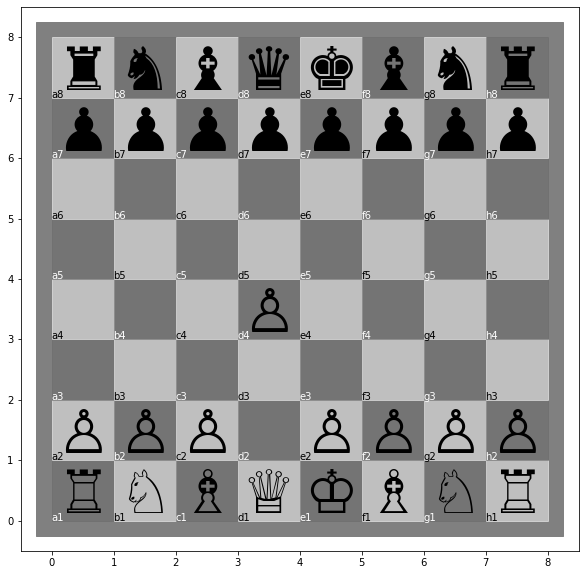

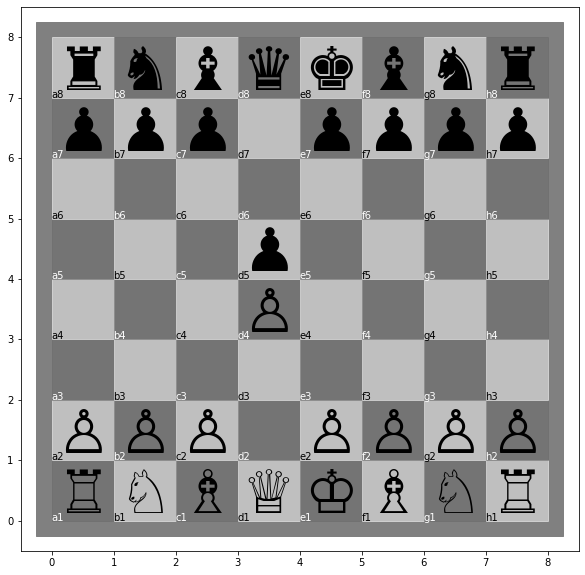

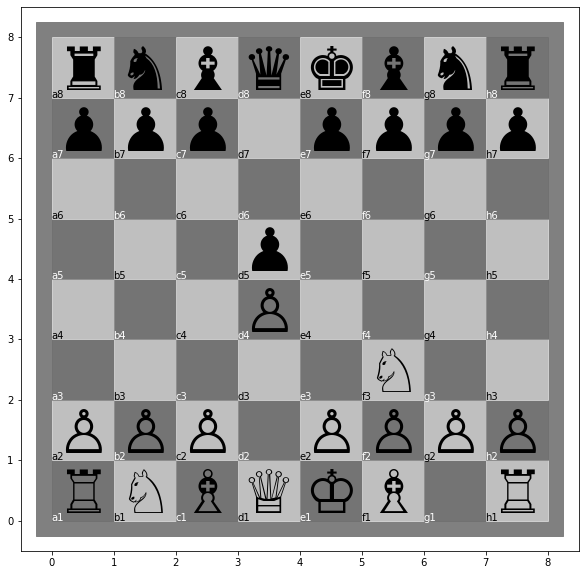

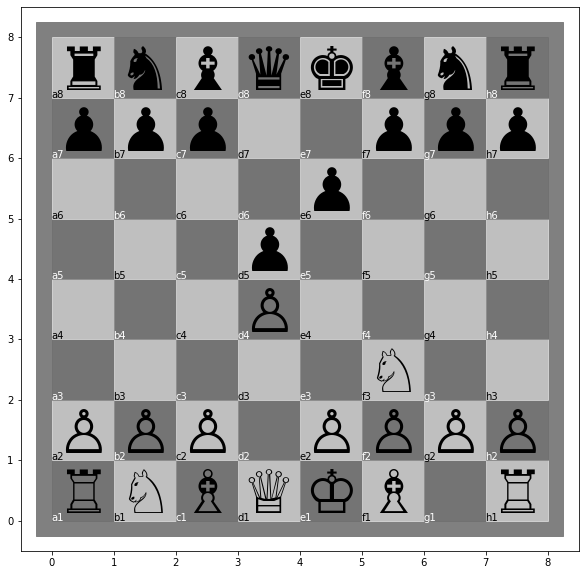

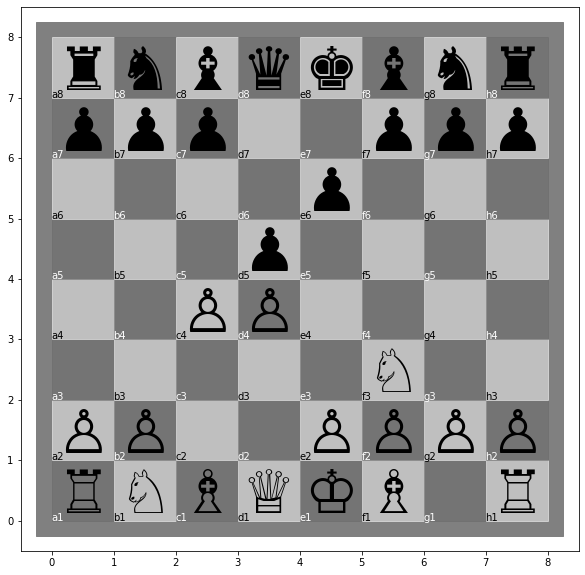

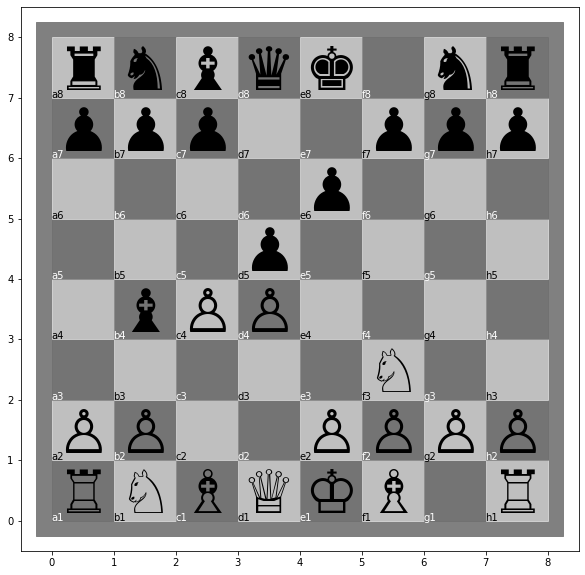

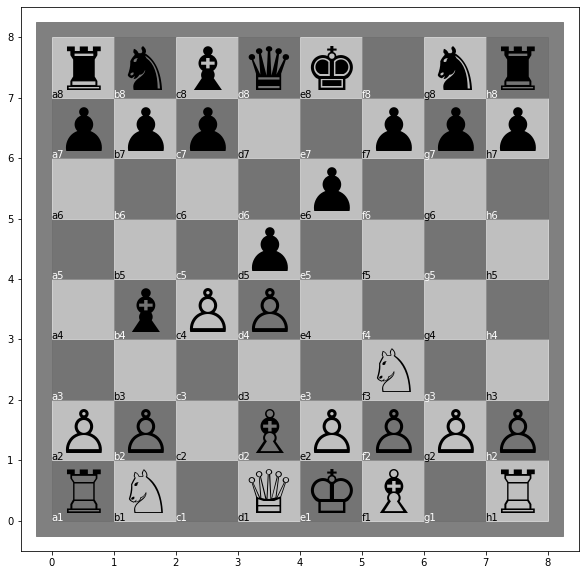

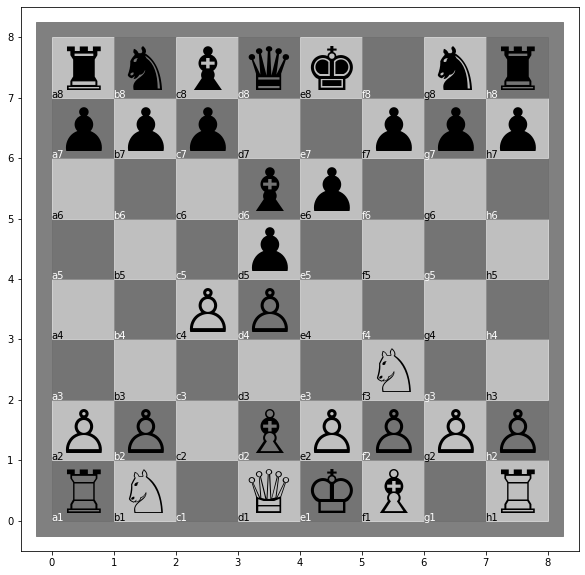

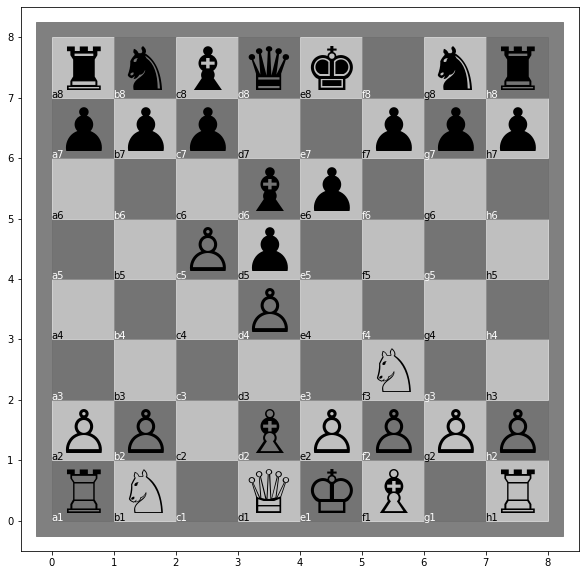

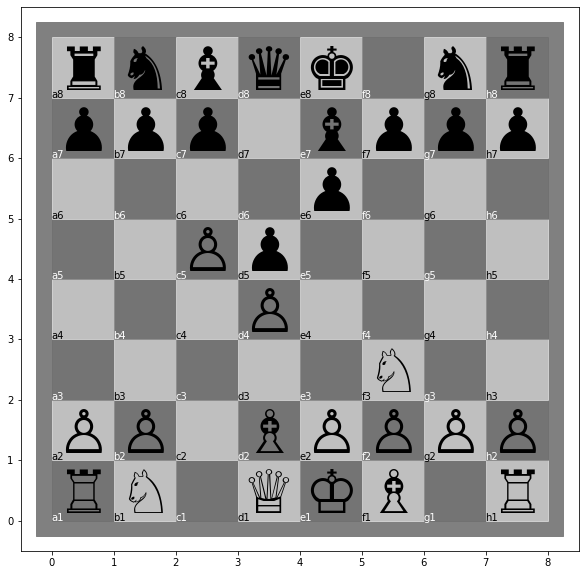

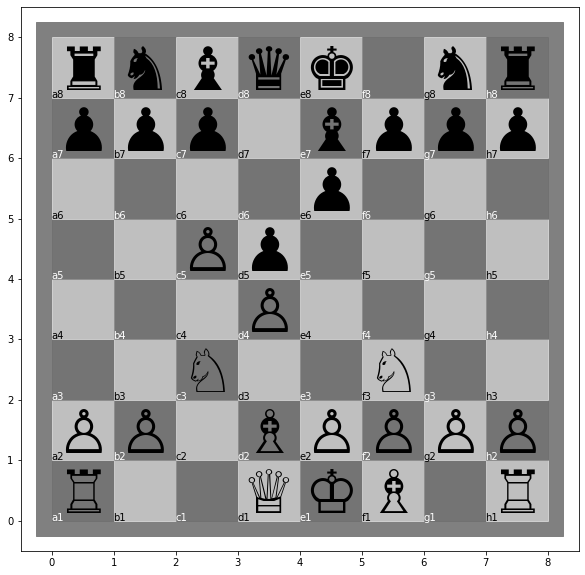

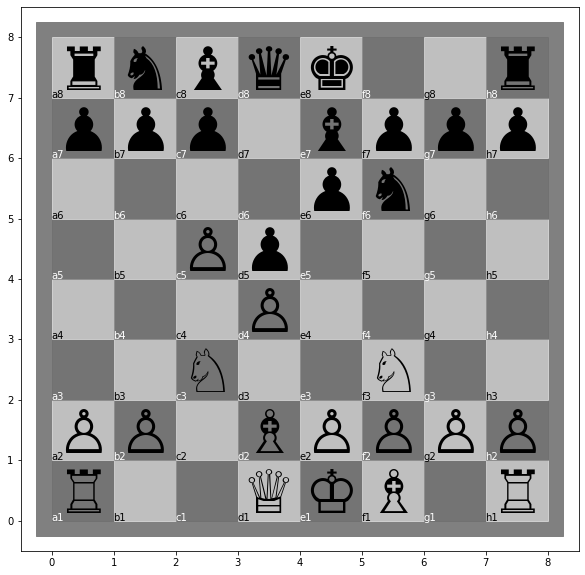

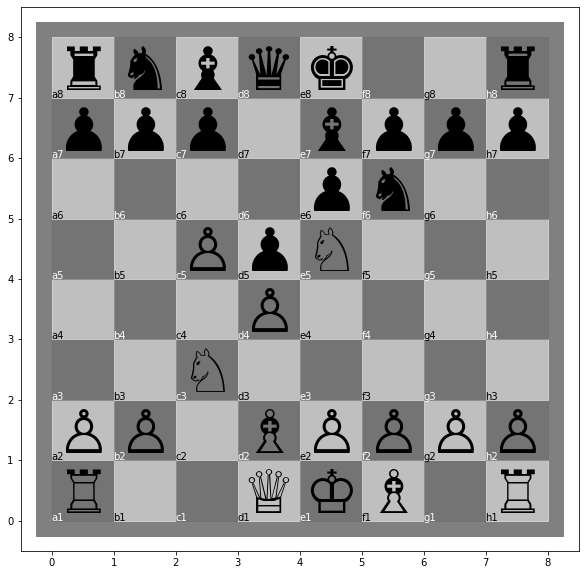

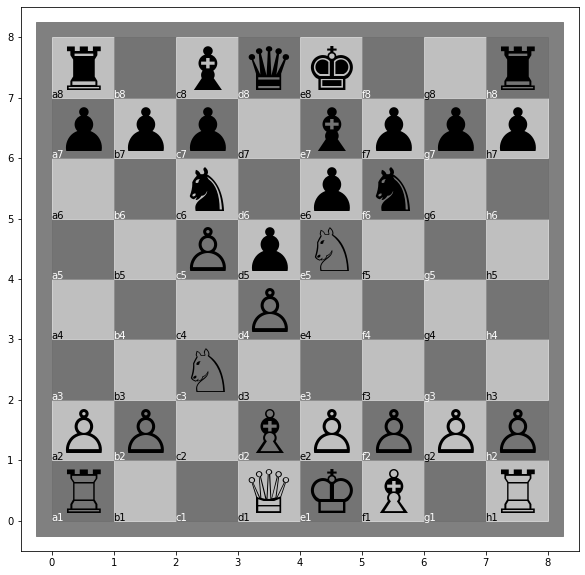

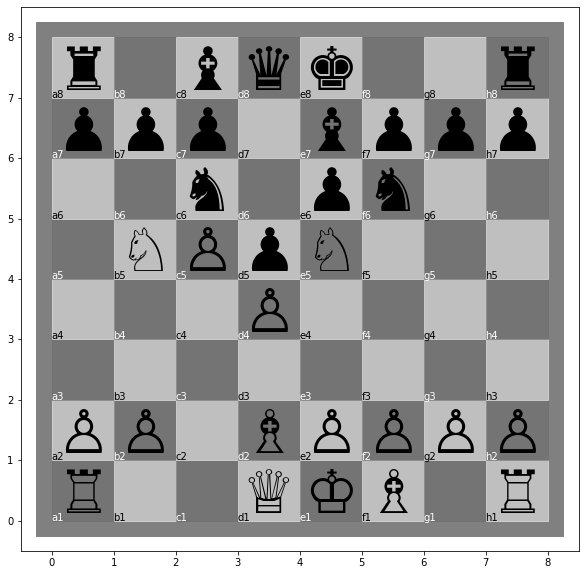

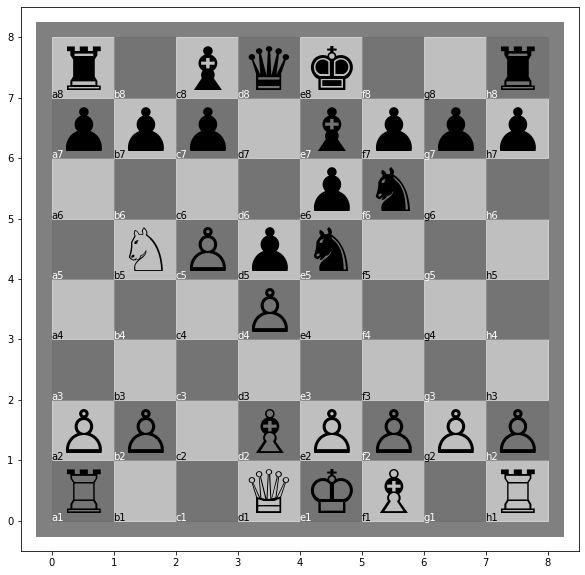

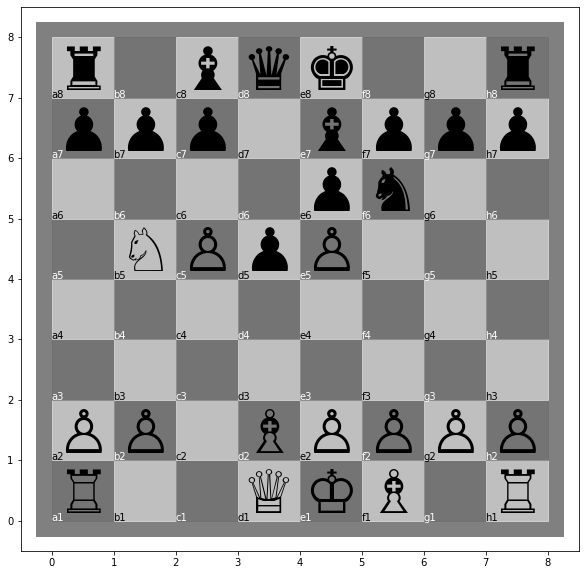

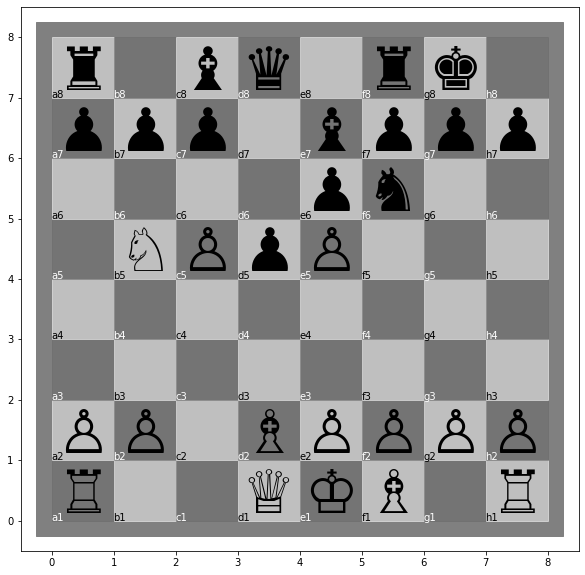

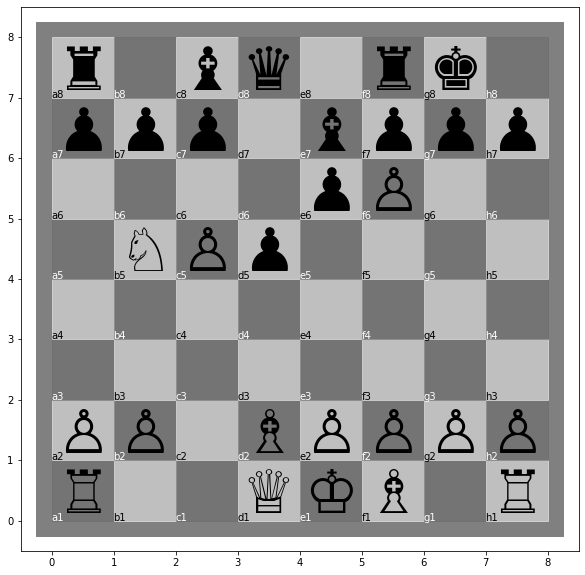

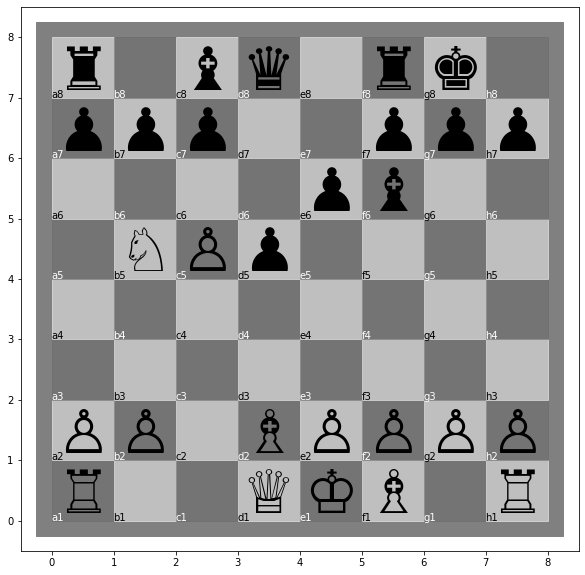

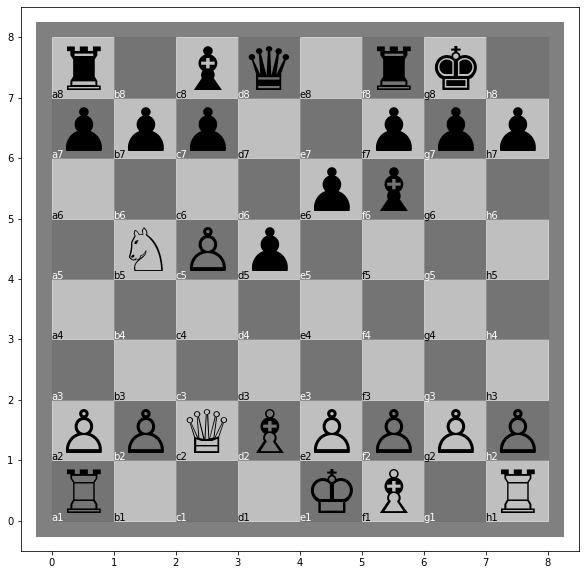

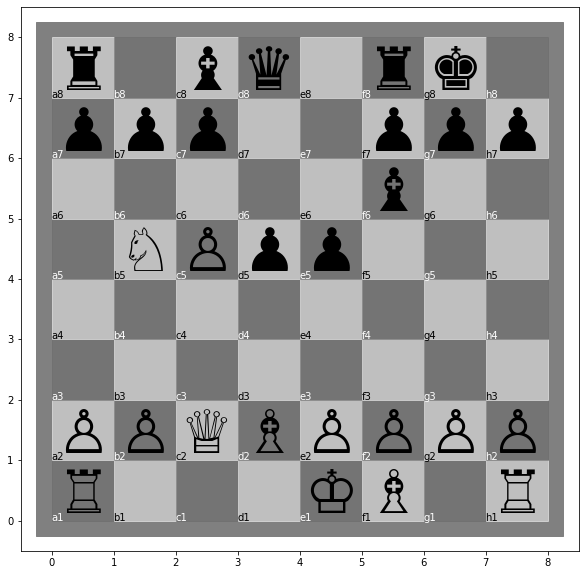

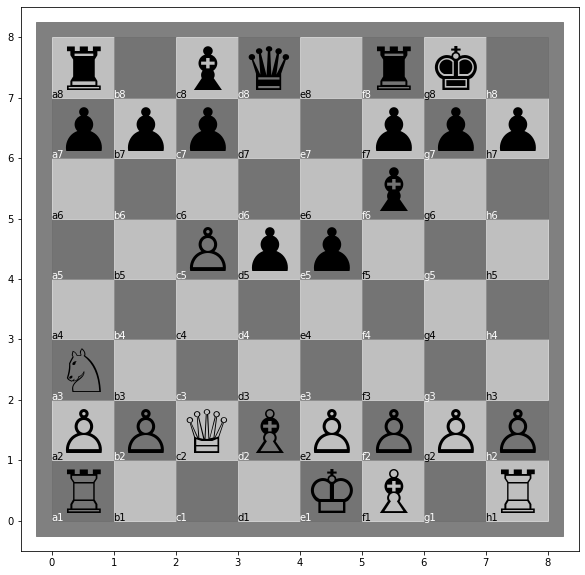

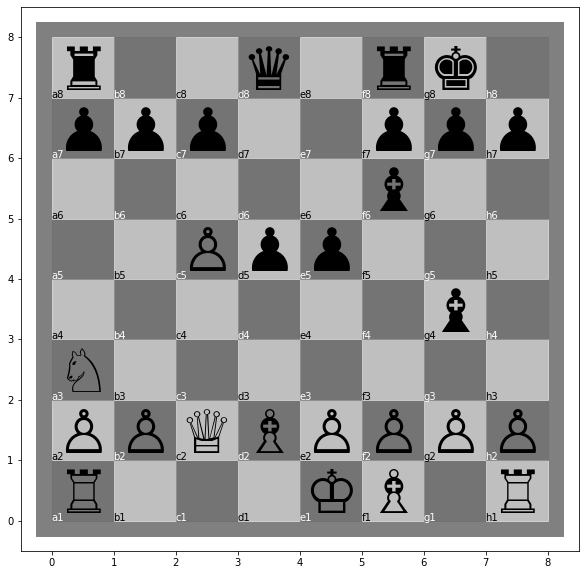

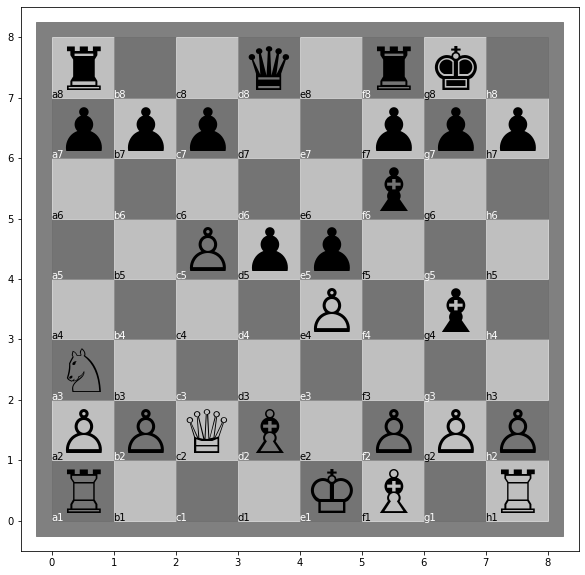

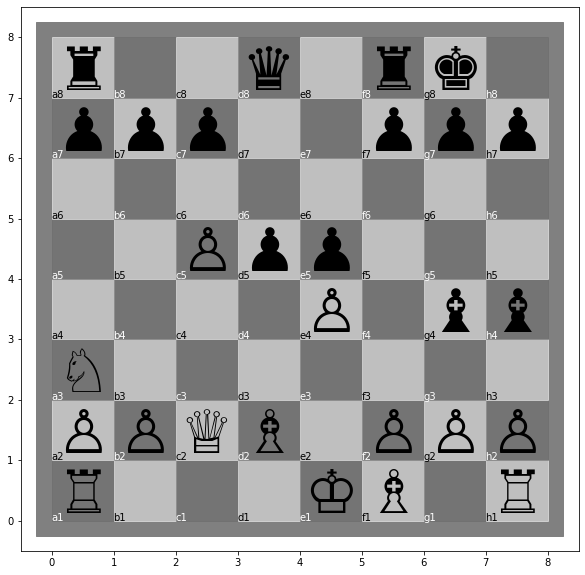

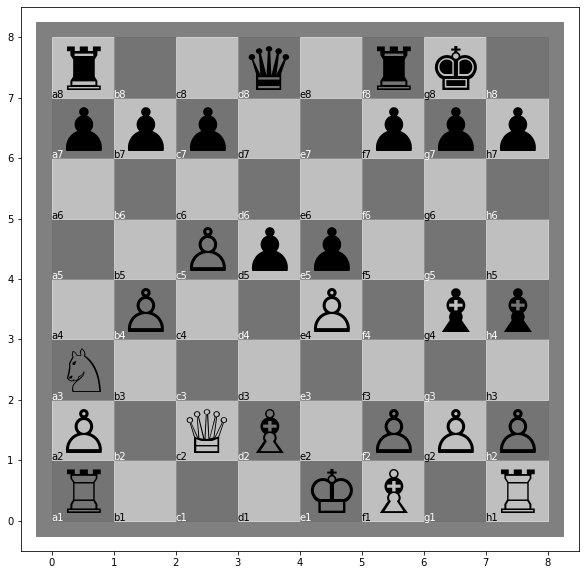

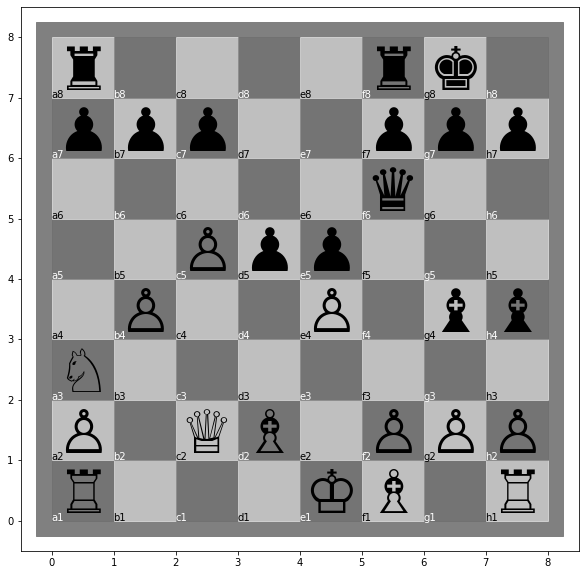

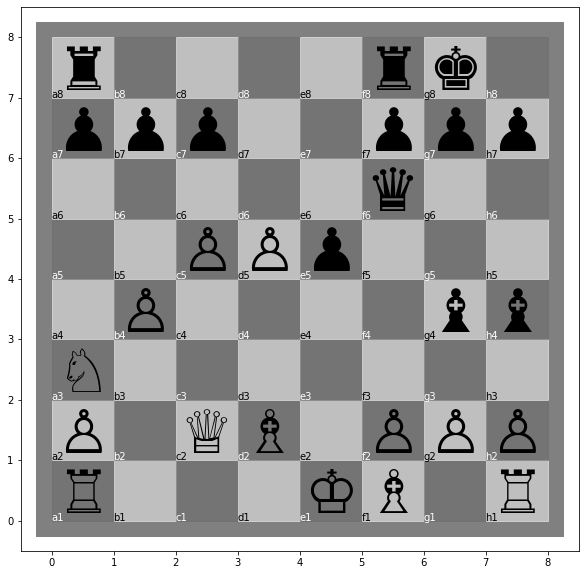

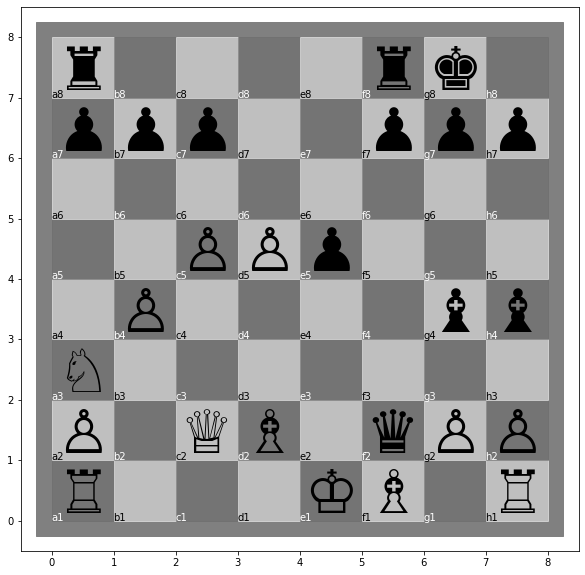

In [75]:
d_board_example = d_board_standard.copy()
game_moves = '1. d4 d5 2. Nf3 e6 3. c4 Bb4+ 4. Bd2 Bd6 5. c5 Be7 6. Nc3 Nf6 7. Ne5 Nc6 8. Nb5 Nxe5 9. dxe5 O-O 10. exf6 Bxf6 11. Qc2 e5 12. Na3 Bg4 13. e4 Bh4 14. b4 Qf6 15. exd5 Qxf2'

l_ch = len(game_moves)
print(game_moves[:l_ch])

print(get_moves_from_game_to_list(game_moves[:l_ch]))

for ii,move in enumerate(get_moves_from_game_to_list(game_moves[:l_ch])):
    print(ii,move)
    if ii%2==0:
        color='w'
    else:
        color='b'
    d_board_example = move_piece_from_move_pawn_simple_board(d_board_example,move,color)
    d_board_example = move_piece_from_move_piece_simple_board(d_board_example,move,color)
    d_board_example = move_piece_from_move_pawn_capture_board(d_board_example,move,color)
    d_board_example = move_piece_from_move_piece_capture_board(d_board_example,move,color)
    d_board_example = move_piece_from_move_piece_ambiguous_board(d_board_example,move,color)
    d_board_example = move_piece_from_move_piece_capture_ambiguous_board(d_board_example,move,color)
    d_board_example = move_piece_from_move_castle(d_board_example,move,color)
    print_board_img(d_board_example,str(ii).zfill(3))

### Checking if the king is in check
- Needs to check for mate as well

In [107]:
def is_the_king_check(board_positions,color):
    # Objective: check if the king is in check
    # Input: current board position
    #        color (PGN does not specify color other than from parity of the element in the list)
    # Output: updated board position dictionary
    for piece in board_positions.keys():
        piece_code = piece[1]
        piece_color = piece[0]
        position = board_positions[piece]
        if position != '_Captured':
            if len([item[-1] for item in get_legal_moves(piece_code,piece_color,position,board_positions)[1] if color + 'K' in item[-1]])>0:
                return True
    return False

In [110]:
def test_is_the_king_check():
    d_board_check_example = {'wKe1':'a1','bQd8': 'b3'}
    assert is_the_king_check(d_board_check_example,'w') == False
    d_board_check_example = {'wKe1':'a1','bQd8': 'a3'}
    assert is_the_king_check(d_board_check_example,'w') == True

In [111]:
ipytest.run()

======================================= test session starts ========================================
platform darwin -- Python 3.9.16, pytest-7.1.3, pluggy-1.0.0
rootdir: /Users/hugocontreras/Documents/DATA_SCIENCE_REVIEW_2023/Shatranj/notebooks
collected 23 items

t_9043a1c056044cf68e69e4f9f679e2ad.py .......................                                [100%]

======================================== 23 passed in 0.41s ========================================


<ExitCode.OK: 0>